##### Image dataset: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset?resource=download
##### Metainfo csv: https://github.com/lgreski/pokemonData/blob/master/Pokemon.csv
##### You can speed up model inference on colab by changing Hardware accelerator in runtime type to any GPU option

In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-k0kc4keg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-k0kc4keg
  Resolved https://github.com/openai/CLIP.git to commit ded190a052fdf4585bd685cee5bc96e0310d2c93
  Preparing metadata (setup.py) ... done


In [40]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE


print(f"GPU device: {torch.cuda.get_device_name(0)}")

GPU device: NVIDIA A100-SXM4-40GB


In [41]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# Updated this function to have batch process 32 at once to get speedup
def clip_inference_image(model, preprocess, image_paths, device, batch_size=32):

    image_embeddings = []

    if device == "cuda":
        effective_batch_size = batch_size
    else:
        effective_batch_size = min(batch_size, 8)

    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), effective_batch_size), desc="Processing images"):
            batch_paths = image_paths[i:i+effective_batch_size]

            batch_images = []
            for img_path in batch_paths:
                img = Image.open(img_path)
                img_preprocessed = preprocess(img)
                batch_images.append(img_preprocessed)

            batch_tensor = torch.stack(batch_images).to(device)

            batch_embeddings = model.encode_image(batch_tensor).detach().cpu().numpy()
            image_embeddings.append(batch_embeddings)

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [ ]:
# ============================
# Qwen3-VL-2B-Instruct helper
# ============================

# If you get import/version issues, install transformers from source:
# pip install -U git+https://github.com/huggingface/transformers

import os
import torch
from PIL import Image
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor


def load_qwen3_vl(model_id="Qwen/Qwen3-VL-2B-Instruct"):
    """
    Load Qwen3-VL model + processor.
    Works on GPU if available (recommended).
    """
    model = Qwen3VLForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype="auto",
        device_map="auto",
    ).eval()

    processor = AutoProcessor.from_pretrained(model_id)
    return model, processor


@torch.no_grad()
def qwen_vl_infer_one(model, processor, image_path, prompt, max_new_tokens=128):
    """
    Run Qwen3-VL on a single image + prompt.
    Returns the generated text.
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text", "text": prompt},
            ],
        }
    ]

    # Build model inputs using Qwen chat template
    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)

    # Deterministic decoding
    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
    )

    # Remove the prompt tokens from the output before decoding
    output_ids_trimmed = [out[len(inp):] for inp, out in zip(inputs.input_ids, output_ids)]

    text = processor.batch_decode(
        output_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]

    return text.strip()


In [47]:
# Question 20: Text queries for Pokemon types

import os
image_dir = '/content/drive/MyDrive/images'
csv_path = '/content/Pokemon.csv'

pokedex = construct_pokedex(csv_path=csv_path, image_dir=image_dir, type_to_load=None)

if len(pokedex) == 0:
    raise ValueError("Count not find Pokemon data.")

print(f"Loaded {len(pokedex)} Pokemon")

# CLIP model
clip_model, clip_preprocess, device = load_clip_model()
print(f"CLIP model loaded on {device}")

# Get image embeddings all of the Pokemon
image_paths = pokedex['image_path'].tolist()
print("Compute image embeddings")
image_embeddings = clip_inference_image(clip_model, clip_preprocess, image_paths, device)
print(image_embeddings.shape)

Loaded 751 Pokemon
CLIP model loaded on cuda
Computing image embeddings...


Processing images: 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]

Image embeddings shape: (751, 768)


In [54]:
type_queries = {
    'Bug': ['type: Bug', 'Bug type Pokemon', 'Pokemon with Bug abilities', 'Bug Pokemon'],
    'Fire': ['type: Fire', 'Fire type Pokemon', 'Pokemon with Fire abilities', 'Fire Pokemon'],
    'Grass': ['type: Grass', 'Grass type Pokemon', 'Pokemon with Grass abilities', 'Grass Pokemon'],
    'Dark': ['type: Dark', 'Dark type Pokemon', 'Pokemon with Dark abilities', 'Dark Pokemon', 'Pokemon Dark', 'Pokemon of Dark'],
    'Dragon': ['type: Dragon', 'Dragon type Pokemon', 'Pokemon with Dragon abilities', 'Dragon Pokemon', 'Pokemon Dragon', 'Pokemon of Dragon']
}

def test_query_template(query_templates, type_name, image_embeddings, pokedex, top_k=5):
    """Test different query templates and return the best one with top-k results"""
    best_query = None
    best_scores = None
    best_indices = None
    best_accuracy = 0

    for query_template in query_templates:
        text_emb = clip_inference_text(clip_model, clip_preprocess, [query_template], device)

        similarities = image_embeddings @ text_emb.T
        similarities = similarities.flatten()

        top_indices = np.argsort(similarities)[::-1][:top_k]
        correct_count = sum(1 for idx in top_indices if pokedex.iloc[idx]['Type1'] == type_name)
        accuracy = correct_count / top_k

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_query = query_template
            best_scores = similarities[top_indices]
            best_indices = top_indices

    return best_query, best_scores, best_indices, best_accuracy

results_q20 = {}
for type_name in ['Bug', 'Fire', 'Grass', 'Dark', 'Dragon']:
    best_query, best_scores, best_indices, accuracy = test_query_template(
        type_queries[type_name], type_name, image_embeddings, pokedex, top_k=5
    )
    results_q20[type_name] = {
        'query': best_query,
        'indices': best_indices,
        'scores': best_scores,
        'pokemon': [pokedex.iloc[idx] for idx in best_indices]
    }
    print(f"{type_name}: Best query = '{best_query}', Accuracy = {accuracy:.2%}")

Bug: Best query = 'Bug type Pokemon', Accuracy = 100.00%
Fire: Best query = 'type: Fire', Accuracy = 100.00%
Grass: Best query = 'Pokemon with Grass abilities', Accuracy = 100.00%
Dark: Best query = 'type: Dark', Accuracy = 60.00%
Dragon: Best query = 'Pokemon of Dragon', Accuracy = 60.00%


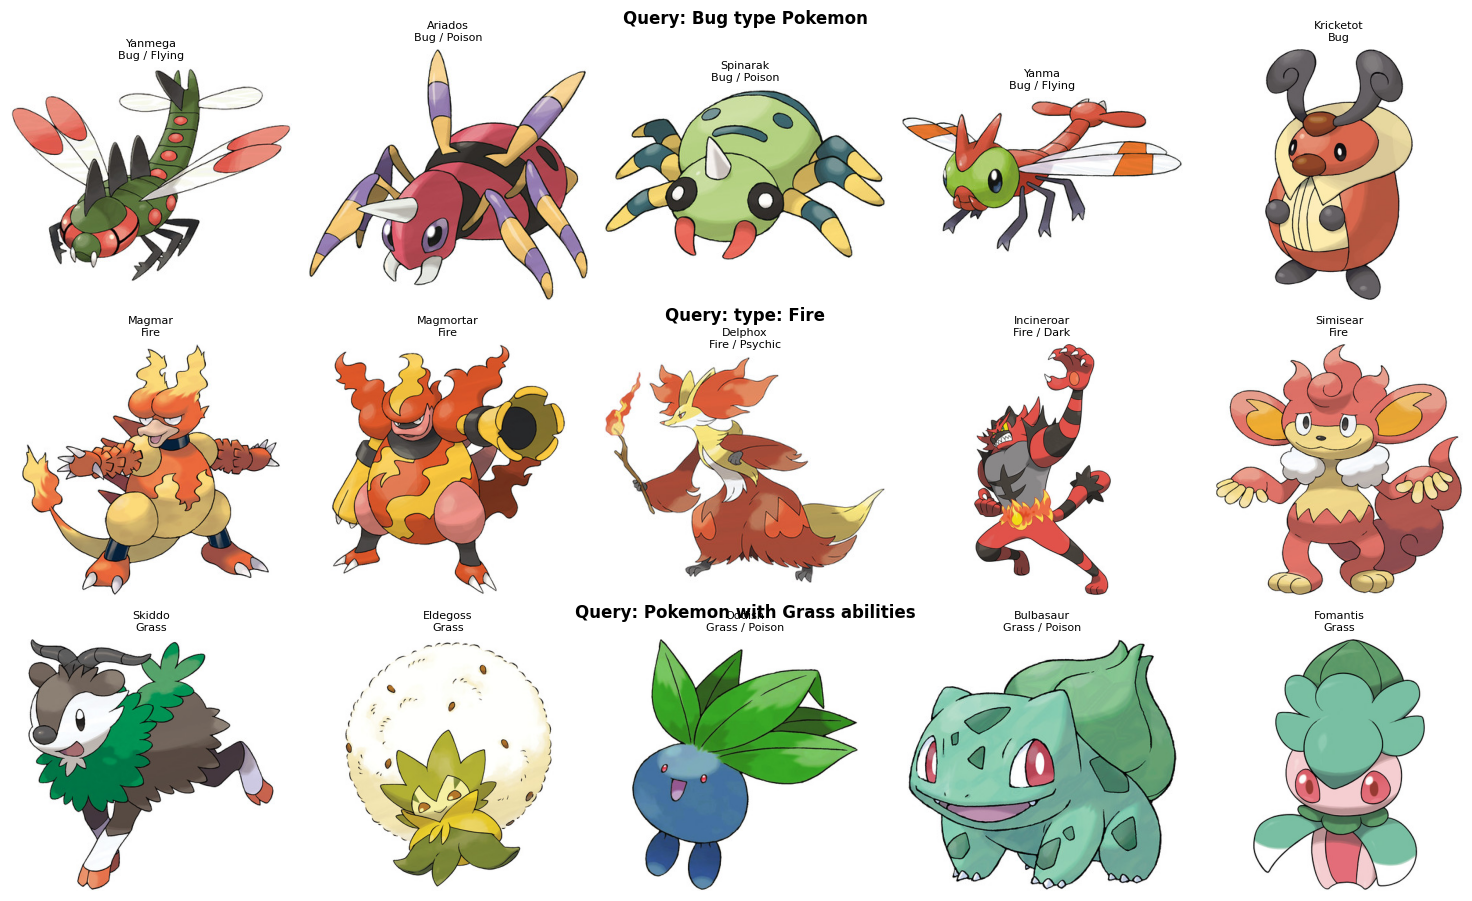


Effectiveness Assessment:
Bug: 5/5 top results have correct Type1
Fire: 5/5 top results have correct Type1
Grass: 5/5 top results have correct Type1


In [53]:
# Pics for top 5 Pokemon in Bug, Fire, Grass
fig = plt.figure(figsize=(15, 9))

for idx, type_name in enumerate(['Bug', 'Fire', 'Grass']):
    result = results_q20[type_name]

    for i, pokemon_idx in enumerate(result['indices']):
        pokemon = pokedex.iloc[pokemon_idx]
        img_path = pokemon['image_path']

        img = Image.open(img_path)
        ax_sub = plt.subplot(3, 5, idx * 5 + i + 1)
        ax_sub.imshow(img)
        ax_sub.axis('off')
        title = f"{pokemon['Name']}\n{pokemon['Type1']}"
        if pd.notna(pokemon['Type2']) and pokemon['Type2'] != '':
            title += f" / {pokemon['Type2']}"
        ax_sub.set_title(title, fontsize=8)

    fig.text(0.5, 0.98 - idx * 0.33, f"Query: {result['query']}",
             ha='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig('question20_1.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nEffectiveness Assessment:")
for type_name in ['Bug', 'Fire', 'Grass']:
    result = results_q20[type_name]
    correct_count = sum(1 for pokemon in result['pokemon'] if pokemon['Type1'] == type_name)
    print(f"{type_name}: {correct_count}/5 top results have correct Type1")

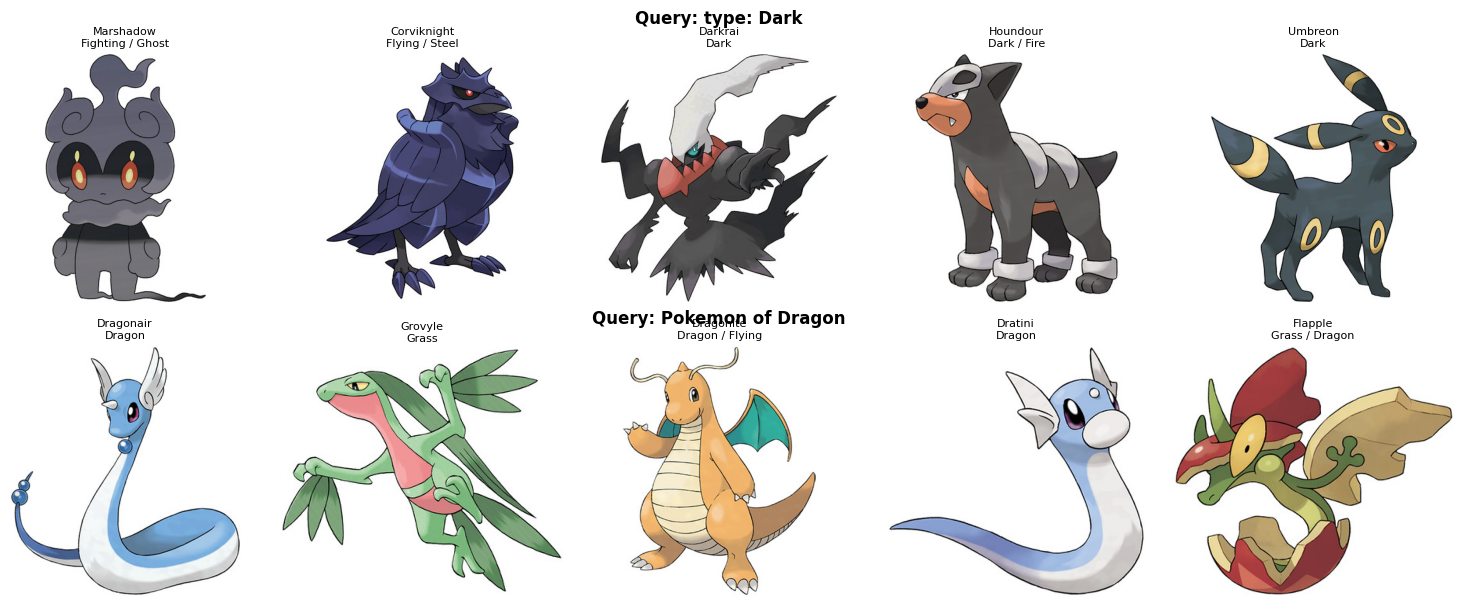


Effectiveness Assessment:
Dark: 3/5 top results have correct Type1
Dragon: 3/5 top results have correct Type1


In [55]:
# Pics for top 5 Pokemon in Dark and Dragon
fig = plt.figure(figsize=(15, 6))

for idx, type_name in enumerate(['Dark', 'Dragon']):
    result = results_q20[type_name]

    for i, pokemon_idx in enumerate(result['indices']):
        pokemon = pokedex.iloc[pokemon_idx]
        img_path = pokemon['image_path']

        img = Image.open(img_path)
        ax_sub = plt.subplot(2, 5, idx * 5 + i + 1)
        ax_sub.imshow(img)
        ax_sub.axis('off')
        title = f"{pokemon['Name']}\n{pokemon['Type1']}"
        if pd.notna(pokemon['Type2']) and pokemon['Type2'] != '':
            title += f" / {pokemon['Type2']}"
        ax_sub.set_title(title, fontsize=8)

    fig.text(0.5, 0.98 - idx * 0.5, f"Query: {result['query']}",
             ha='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig('question20_2.png', dpi=150, bbox_inches='tight')
plt.show()

# Could not get above 3/5 with any keywords for Dark and Dragon :(

print("\nEffectiveness Assessment:")
for type_name in ['Dark', 'Dragon']:
    result = results_q20[type_name]
    correct_count = sum(1 for pokemon in result['pokemon'] if pokemon['Type1'] == type_name)
    print(f"{type_name}: {correct_count}/5 top results have correct Type1")

In [56]:
# Question 21: Randomly select 10 Pokemon and find their most relevant types


all_types = set()
for _, row in pokedex.iterrows():
    if pd.notna(row['Type1']):
        all_types.add(row['Type1'])
    if pd.notna(row['Type2']) and row['Type2'] != '':
        all_types.add(row['Type2'])

all_types = sorted(list(all_types))
print(f"Found {len(all_types)} unique types: {all_types}")

type_queries_q21 = [f"type: {t}" for t in all_types]

print("Computing text embeddings for all types")
text_embeddings_all_types = clip_inference_text(clip_model, clip_preprocess, type_queries_q21, device)
print(f"Text embeddings shape: {text_embeddings_all_types.shape}")

np.random.seed(42)
random_indices = np.random.choice(len(pokedex), size=10, replace=False)
random_pokemon = pokedex.iloc[random_indices]

for idx, pokemon_idx in enumerate(random_indices):
    pokemon = pokedex.iloc[pokemon_idx]
    print(f"{idx+1}. {pokemon['Name']} - Type1: {pokemon['Type1']}, Type2: {pokemon['Type2']}")

Found 18 unique types: ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']
Computing text embeddings for all types
Text embeddings shape: (18, 768)
1. Sawsbuck - Type1: Normal, Type2: Grass
2. Croagunk - Type1: Poison, Type2: Fighting
3. Hoppip - Type1: Grass, Type2: Flying
4. Spinda - Type1: Normal, Type2: 
5. Torterra - Type1: Grass, Type2: Ground
6. Polteageist - Type1: Ghost, Type2: 
7. Mismagius - Type1: Ghost, Type2: 
8. Teddiursa - Type1: Normal, Type2: 
9. Chespin - Type1: Grass, Type2: 
10. Dracozolt - Type1: Electric, Type2: Dragon


In [65]:
results_q21 = {}

for pokemon_idx in random_indices:
    pokemon = pokedex.iloc[pokemon_idx]
    pokemon_name = pokemon['Name']

    img_emb = image_embeddings[pokemon_idx:pokemon_idx+1]

    similarities = (img_emb @ text_embeddings_all_types.T).flatten()

    top5_indices = np.argsort(similarities)[::-1][:5]
    top5_types = [all_types[i] for i in top5_indices]
    top5_scores = similarities[top5_indices]

    results_q21[pokemon_idx] = {
        'pokemon': pokemon,
        'top5_types': top5_types,
        'top5_scores': top5_scores
    }

    print(f"{pokemon_name} (Type1: {pokemon['Type1']}, Type2: {pokemon['Type2']}):")
    for i, (type_name, score) in enumerate(zip(top5_types, top5_scores)):
        print(f"  {i+1}. {type_name}: {score:.5f}")

Sawsbuck (Type1: Normal, Type2: Grass):
  1. Grass: 0.22229
  2. Electric: 0.18726
  3. Dark: 0.18542
  4. Water: 0.17957
  5. Fire: 0.17761
Croagunk (Type1: Poison, Type2: Fighting):
  1. Water: 0.21838
  2. Fighting: 0.21765
  3. Dark: 0.21497
  4. Electric: 0.21448
  5. Ground: 0.21155
Hoppip (Type1: Grass, Type2: Flying):
  1. Grass: 0.23389
  2. Poison: 0.22742
  3. Fairy: 0.21899
  4. Electric: 0.21545
  5. Water: 0.20227
Spinda (Type1: Normal, Type2: ):
  1. Psychic: 0.20618
  2. Electric: 0.19482
  3. Ghost: 0.19116
  4. Fighting: 0.18665
  5. Poison: 0.18555
Torterra (Type1: Grass, Type2: Ground):
  1. Rock: 0.22327
  2. Grass: 0.22131
  3. Water: 0.21130
  4. Electric: 0.20679
  5. Steel: 0.20654
Polteageist (Type1: Ghost, Type2: ):
  1. Water: 0.22095
  2. Poison: 0.21594
  3. Ghost: 0.20947
  4. Psychic: 0.20935
  5. Ice: 0.20752
Mismagius (Type1: Ghost, Type2: ):
  1. Poison: 0.22473
  2. Ghost: 0.22449
  3. Psychic: 0.22095
  4. Dark: 0.20850
  5. Grass: 0.20410
Teddiursa


--- Pokemon Details ---

1. Sawsbuck
   Ground Truth Type1: Normal
   Ground Truth Type2: Grass
   Top 5 Predicted Types:
     1. Grass (0.222)
     2. Electric (0.187)
     3. Dark (0.185)
     4. Water (0.180)
     5. Fire (0.178)

2. Croagunk
   Ground Truth Type1: Poison
   Ground Truth Type2: Fighting
   Top 5 Predicted Types:
     1. Water (0.218)
     2. Fighting (0.218)
     3. Dark (0.215)
     4. Electric (0.214)
     5. Ground (0.212)

3. Hoppip
   Ground Truth Type1: Grass
   Ground Truth Type2: Flying
   Top 5 Predicted Types:
     1. Grass (0.234)
     2. Poison (0.227)
     3. Fairy (0.219)
     4. Electric (0.215)
     5. Water (0.202)

4. Spinda
   Ground Truth Type1: Normal
   Top 5 Predicted Types:
     1. Psychic (0.206)
     2. Electric (0.195)
     3. Ghost (0.191)
     4. Fighting (0.187)
     5. Poison (0.186)

5. Torterra
   Ground Truth Type1: Grass
   Ground Truth Type2: Ground
   Top 5 Predicted Types:
     1. Rock (0.223)
     2. Grass (0.221)
     3. Wate

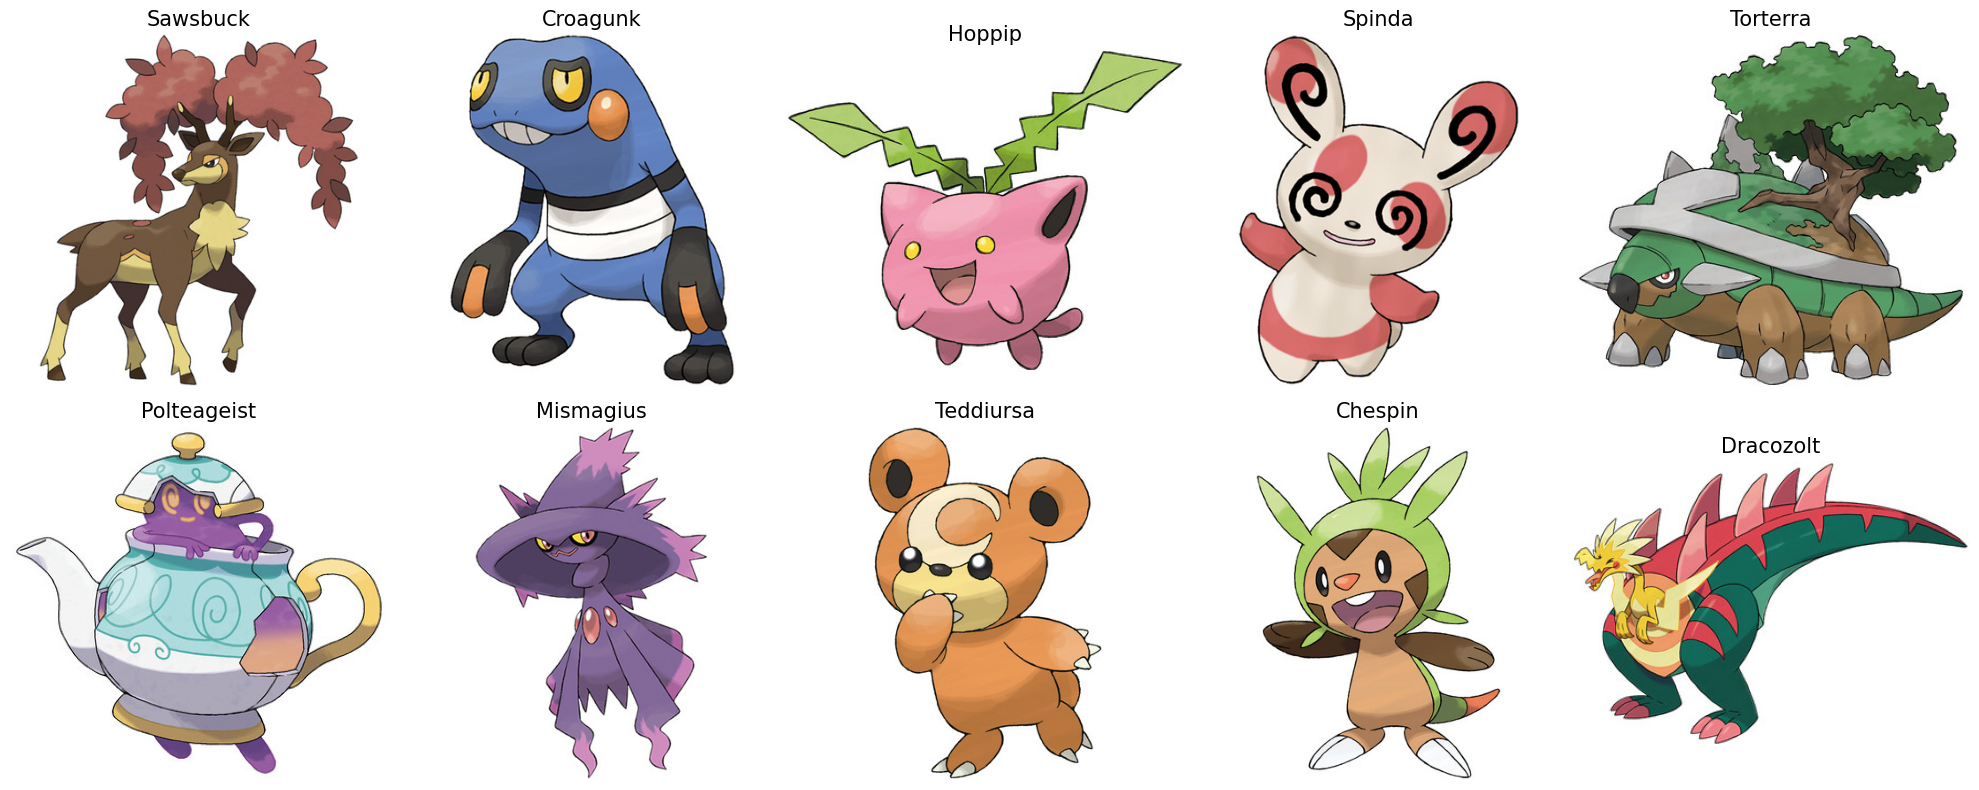

In [59]:
# Pics for 10 randomly selected Pokemon with predicted types
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

print("\n--- Pokemon Details ---")

for idx, pokemon_idx in enumerate(random_indices):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]

    pokemon = pokedex.iloc[pokemon_idx]
    result = results_q21[pokemon_idx]

    img = Image.open(pokemon['image_path'])
    ax.imshow(img)
    ax.axis('off')

    # Only putting the Pokemon name in the image so that image is readable
    # Printing all required details to terminal
    ax.set_title(pokemon['Name'], fontsize=15)
    print(f"\n{idx+1}. {pokemon['Name']}")
    print(f"   Ground Truth Type1: {pokemon['Type1']}")
    if pd.notna(pokemon['Type2']) and pokemon['Type2'] != '':
        print(f"   Ground Truth Type2: {pokemon['Type2']}")
    print("   Top 5 Predicted Types:")
    for i, (type_name, score) in enumerate(zip(result['top5_types'], result['top5_scores'])):
        print(f"     {i+1}. {type_name} ({score:.3f})")

plt.tight_layout()
plt.savefig('question21.png', dpi=150, bbox_inches='tight')
plt.show()

In [62]:
# Question 22

print("Evaluating CLIP on all Pokemon images")
print(f"Total Pokemon: {len(pokedex)}")
print(f"Total types: {len(all_types)}")

all_top5_predictions = []
ground_truth_type1 = []

for pokemon_idx in range(len(pokedex)):
    pokemon = pokedex.iloc[pokemon_idx]

    img_emb = image_embeddings[pokemon_idx:pokemon_idx+1]
    similarities = (img_emb @ text_embeddings_all_types.T).flatten()

    top5_indices = np.argsort(similarities)[::-1][:5]
    top5_types = [all_types[i] for i in top5_indices]

    all_top5_predictions.append(top5_types)
    ground_truth_type1.append(pokemon['Type1'])

acc_at_1 = 0
hit_at_5 = 0

for i in range(len(pokedex)):
    predicted_type1 = all_top5_predictions[i][0]
    true_type1 = ground_truth_type1[i]

    if predicted_type1 == true_type1:
        acc_at_1 += 1

    if true_type1 in all_top5_predictions[i]:
        hit_at_5 += 1

acc_at_1 /= len(pokedex)
hit_at_5 /= len(pokedex)

print(f"Results:")
print(f"Accuracy@1 (Acc@1): {acc_at_1:.4f} ({acc_at_1*100:.2f}%)")
print(f"Hit@5 (Recall@5): {hit_at_5:.4f} ({hit_at_5*100:.2f}%)")
print(f"Acc@1 counts: {sum(1 for i in range(len(pokedex)) if all_top5_predictions[i][0] == ground_truth_type1[i])}/{len(pokedex)}")
print(f"Hit@5 counts: {sum(1 for i in range(len(pokedex)) if ground_truth_type1[i] in all_top5_predictions[i])}/{len(pokedex)}")

Evaluating CLIP on all Pokemon images
Total Pokemon: 751
Total types: 18
Results:
Accuracy@1 (Acc@1): 0.3755 (37.55%)
Hit@5 (Recall@5): 0.7071 (70.71%)
Acc@1 counts: 282/751
Hit@5 counts: 531/751


In [63]:
# Quesiton 23

model_vlm, processor_vlm = load_qwen3_vl()

vlm_reranked_predictions = []

print("Reranking CLIP predictions with VLM")
for pokemon_idx in tqdm(range(len(pokedex))):
    pokemon = pokedex.iloc[pokemon_idx]
    image_path = pokemon['image_path']

    clip_top5 = all_top5_predictions[pokemon_idx]

    candidate_list = ", ".join(clip_top5)
    prompt = f"""Given the Pokemon image, select one most likely primary type from this candidate list: [{candidate_list}].

Respond with only the type name from the candidate list, nothing else."""

    vlm_output = qwen_vl_infer_one(model_vlm, processor_vlm, image_path, prompt, max_new_tokens=32)

    vlm_output_clean = vlm_output.strip().replace(".", "").replace(",", "")

    predicted_type = None
    for candidate in clip_top5:
        if candidate.lower() in vlm_output_clean.lower() or vlm_output_clean.lower() in candidate.lower():
            predicted_type = candidate
            break

    if predicted_type is None:
        predicted_type = clip_top5[0]

    vlm_reranked_predictions.append(predicted_type)

print(f"VLM processing complete.")

Loading weights:   0%|          | 0/625 [00:00<?, ?it/s]

Reranking CLIP predictions with VLM


100%|██████████| 751/751 [01:49<00:00,  6.89it/s]

VLM processing complete.


In [64]:
# Calculate VLM-reranked Acc@1
vlm_acc_at_1 = 0
for i in range(len(pokedex)):
    if vlm_reranked_predictions[i] == ground_truth_type1[i]:
        vlm_acc_at_1 += 1

vlm_acc_at_1 /= len(pokedex)

print("="*60)
print("Comparison Table")
print("="*60)
print(f"{'Metric':<30} {'Value':<15} {'Percentage':<15}")
print("-"*60)
print(f"{'CLIP Acc@1':<30} {acc_at_1:<15.4f} {acc_at_1*100:<15.2f}%")
print(f"{'CLIP Hit@5':<30} {hit_at_5:<15.4f} {hit_at_5*100:<15.2f}%")
print(f"{'VLM-reranked Acc@1':<30} {vlm_acc_at_1:<15.4f} {vlm_acc_at_1*100:<15.2f}%")
print("="*60)

# Calculate improvement
improvement = vlm_acc_at_1 - acc_at_1
improvement_pct = (improvement / acc_at_1 * 100) if acc_at_1 > 0 else 0
print(f"Improvement: {improvement:+.4f} ({improvement_pct:+.2f}% relative improvement)")

# Examples
print("="*60)
print("Example predictions for the first 10 Pokemon")
print("="*60)
for i in range(min(10, len(pokedex))):
    pokemon = pokedex.iloc[i]
    print(f"{i+1}. {pokemon['Name']}")
    print(f"   Ground Truth Type1: {ground_truth_type1[i]}")
    if pd.notna(pokemon['Type2']):
        print(f"   Ground Truth Type2: {pokemon['Type2']}")
    print(f"   CLIP Top-1: {all_top5_predictions[i][0]}")
    print(f"   CLIP Top-5: {all_top5_predictions[i]}")
    print(f"   VLM Reranked: {vlm_reranked_predictions[i]}")
    print(f"   CLIP Correct: {'Correct' if all_top5_predictions[i][0] == ground_truth_type1[i] else 'Incorrect'}")
    print(f"   VLM Correct: {'Correct' if vlm_reranked_predictions[i] == ground_truth_type1[i] else 'Incorrect'}")

Comparison Table
Metric                         Value           Percentage     
------------------------------------------------------------
CLIP Acc@1                     0.3755          37.55          %
CLIP Hit@5                     0.7071          70.71          %
VLM-reranked Acc@1             0.4101          41.01          %
Improvement: +0.0346 (+9.22% relative improvement)
Example predictions for the first 10 Pokemon
1. Bulbasaur
   Ground Truth Type1: Grass
   Ground Truth Type2: Poison
   CLIP Top-1: Grass
   CLIP Top-5: ['Grass', 'Water', 'Poison', 'Electric', 'Ice']
   VLM Reranked: Grass
   CLIP Correct: Correct
   VLM Correct: Correct
2. Ivysaur
   Ground Truth Type1: Grass
   Ground Truth Type2: Poison
   CLIP Top-1: Grass
   CLIP Top-5: ['Grass', 'Water', 'Poison', 'Fighting', 'Ice']
   VLM Reranked: Grass
   CLIP Correct: Correct
   VLM Correct: Correct
3. Charmander
   Ground Truth Type1: Fire
   Ground Truth Type2: 
   CLIP Top-1: Fire
   CLIP Top-5: ['Fire', 'Water'

## Did VLM reranking help?

Yes, as shown in the table above, VLM reranking directly improved performance, achieving a 9.22% relative increase in classification accuracy, raising Acc@1 from 37.55% to 41.01%. We see that while CLIP is an effective retriever, as shown by its high 70.71% Hit@5, CLIP lacks the fine-grained reasoning to consistently rank the correct type as its top choice. By using the VLM model to reason over image and text tokens, our system was able to evaluate CLIP’s top five candidates and sometime save the correct label as we see with the Caterpie example above.